In [467]:
import pymaster as nmt
import healpy as hp
import numpy as np

import pysm3
import pysm3.units as u

import matplotlib.pyplot as plt

import importlib
import copy
%matplotlib inline

In [507]:
import seaborn as sea
sea.set(rc={'figure.figsize':(11.7,8.27)})
sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

In [10]:
Nside = 128

In [198]:
mask_spass_256 = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_spass_256.npy')
mask_128 = hp.ud_grade(mask_spass_1024, nside_out=128)
mask_128 = np.logical_not(np.logical_not(mask_128))

In [241]:
len(mask_128)

196608

196608

In [199]:
mask_apo = nmt.mask_apodization(mask_128, 6, apotype='C2')

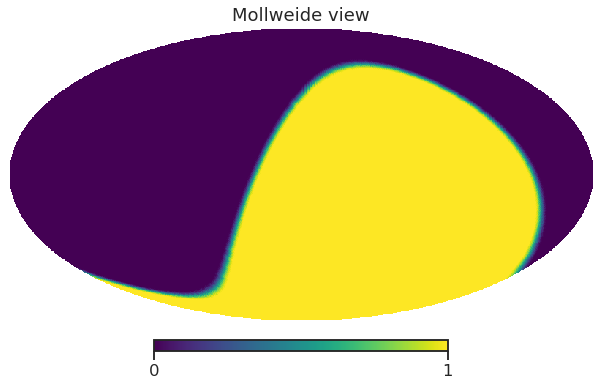

In [200]:
hp.mollview(mask_apo, cmap = 'viridis')

In [376]:
sky = pysm3.Sky(nside=Nside, preset_strings=["s0"])
maps = sky.get_emission(30 * u.GHz)

/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/synch_t_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/synch_q_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/synch_u_new.fits
  warnings.warn(f"Access data from {full_path}")


In [377]:
sl = hp.anafast(maps) #TT, EE, BB, TE, EB, TB

In [378]:
sl.shape

(6, 384)

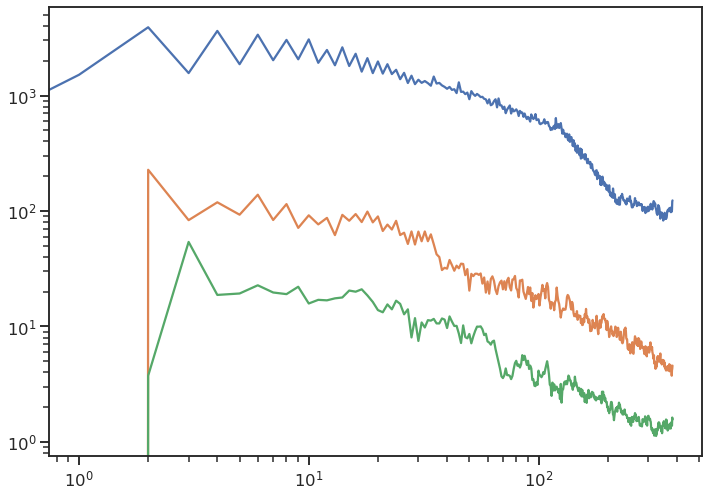

In [379]:
ell = np.arange(len(sl[0]))
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[0])
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[1])
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[2])

In [90]:
sl_fake_TT = (1e5*ell[1:].astype(float)**(-2.7))
sl_fake_EE = (3*1e3*ell[1:].astype(float)**(-2.7))
sl_fake_BB = (0.5*1e3*ell[1:].astype(float)**(-2.7))

Text(0.5, 1.0, 'Cl of pure synchrotron at 30GHz')

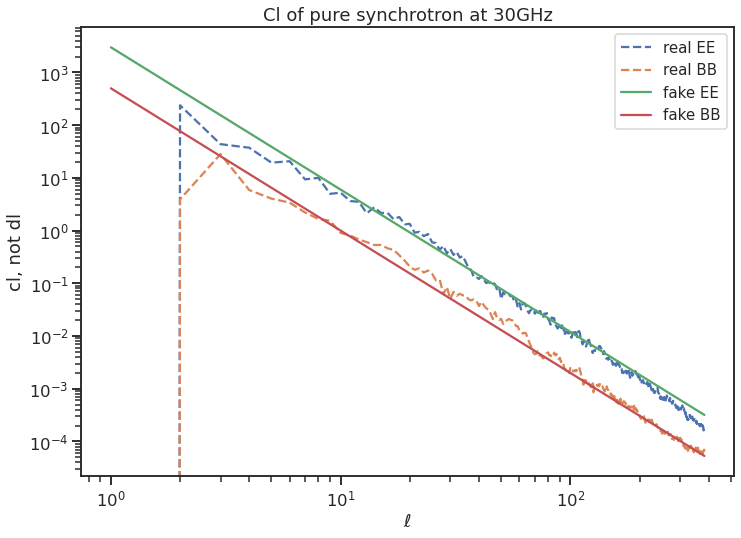

In [226]:
# plt.loglog(ell, sl[0])
plt.loglog(ell, sl[1], '--', label = 'real EE')
plt.loglog(ell, sl[2], '--', label = 'real BB')

# plt.loglog(ell[1:], sl_fake_TT)
plt.loglog(ell[1:], sl_fake_EE, label = 'fake EE')
plt.loglog(ell[1:], sl_fake_BB, label = 'fake BB')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('cl, not dl')

plt.title('Cl of pure synchrotron at 30GHz')

# Full-sky, hp.anafast

In [227]:
sl_fake = np.array((sl_fake_TT, sl_fake_EE, sl_fake_BB, np.zeros_like(sl_fake_TT)))
sync_maps = hp.synfast(sl_fake, nside = Nside, new = True)

In [228]:
sl_hat = hp.anafast(sync_maps)

Text(0, 0.5, 'cl, not dl')

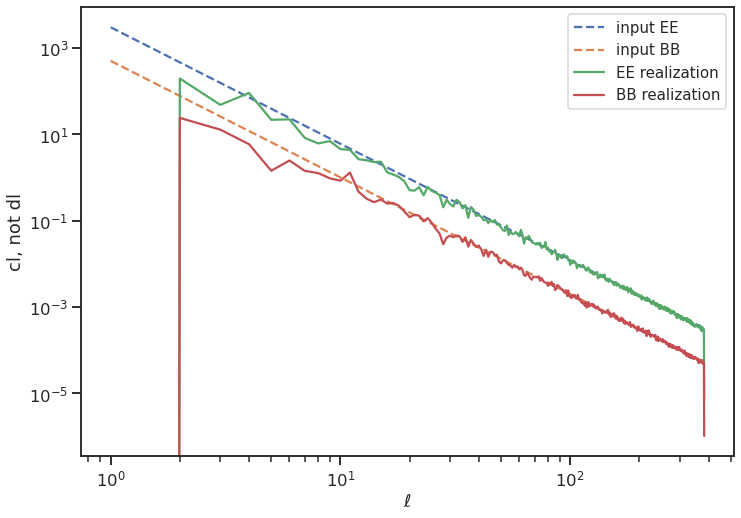

In [233]:
# plt.loglog(ell, sl[0])
# plt.loglog(ell, sl[1])
# plt.loglog(ell, sl[2])

# plt.loglog(ell[1:], sl_fake_TT)
plt.loglog(ell[1:], sl_fake_EE, '--', label = 'input EE')
plt.loglog(ell[1:], sl_fake_BB, '--', label = 'input BB')

# plt.loglog(ell, sl_hat[0])
plt.loglog(ell, sl_hat[1], label = 'EE realization')
plt.loglog(ell, sl_hat[2], label = 'BB realization')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('cl, not dl')

# partial sky, Namaster

In [143]:
import bandpowers
importlib.reload(bandpowers)

<module 'bandpowers' from '/global/u2/j/jianyao/foreground/bandpowers.py'>

In [144]:
from BP_beam_nmt_bin import BPE as BPE_beam
from bandpowers import BPE as BPE

In [146]:
est = BPE(mask_128, Nside, 20, 300)

In [235]:
len(est.ell_n)

14

## one map

In [150]:
dl_all = est.Auto_TEB(sync_maps) #TT TE TB EE EB BB.
EE = dl_all[3]; BB = dl_all[5]

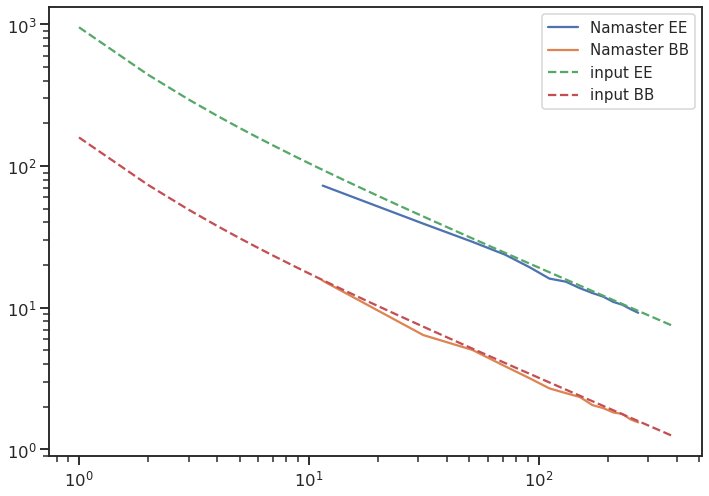

In [164]:
plt.loglog(est.ell_n, EE, label = 'Namaster EE')
plt.loglog(est.ell_n, BB, label = 'Namaster BB')

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('Dl')

## 50 maps

In [165]:
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])

In [166]:
EEs = np.array((EEs));BBs = np.array((BBs));

In [170]:
EE_mean = np.mean(EEs, axis = 0)
EE_std = np.std(EEs, axis = 0)
BB_mean = np.mean(BBs, axis = 0)
BB_std = np.std(BBs, axis = 0)

In [174]:
BB_std

array([2.86233424, 0.3862511 , 0.19584326, 0.15081334, 0.11844633,
       0.07943103, 0.05959578, 0.05416717, 0.05000915, 0.0541737 ,
       0.04086276, 0.03804988, 0.03382354, 0.03602194])

In [236]:
# plt.errorbar(est.ell_n, EE_mean, EE_std, label = 'Namaster EE')
# plt.errorbar(est.ell_n, BB_mean, BB_std, label = 'Namaster BB')

plt.loglog(est.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est.ell_n, BB_mean,'o-', label = 'Namaster BB')
plt.fill_between(est.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.5)
plt.fill_between(est.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.5)

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

# Overlapped region

In [205]:
mask_cbass_256 = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_cbass_256.npy')

mask_both = hp.ud_grade(mask_cbass_256*mask_spass_256, nside_out=128)
mask_both = np.logical_not(np.logical_not(mask_both))

In [246]:
mask_both.sum()/(12*128**2)

0.12993876139322916

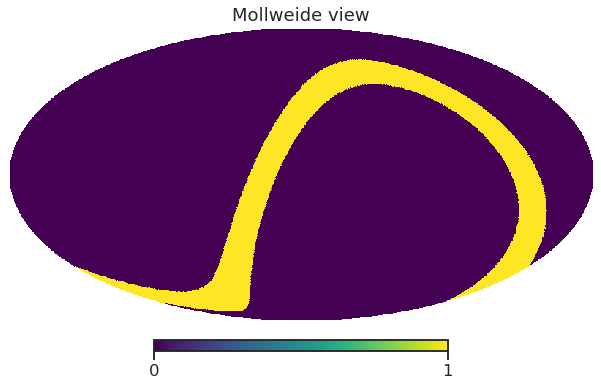

In [247]:
hp.mollview(mask_both, cmap = 'viridis')

In [342]:
est_both = BPE(mask_both, Nside, 20, 300)
est_use = est_both
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est_use.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])
    
EEs = np.array((EEs));BBs = np.array((BBs));

EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0, ddof = 1)
BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0, ddof = 1)

In [343]:
EE_bin = est_use.b.bin_cell(sl_fake_EE[0:301])
BB_bin = est_use.b.bin_cell(sl_fake_BB[0:301])

(5, 400)

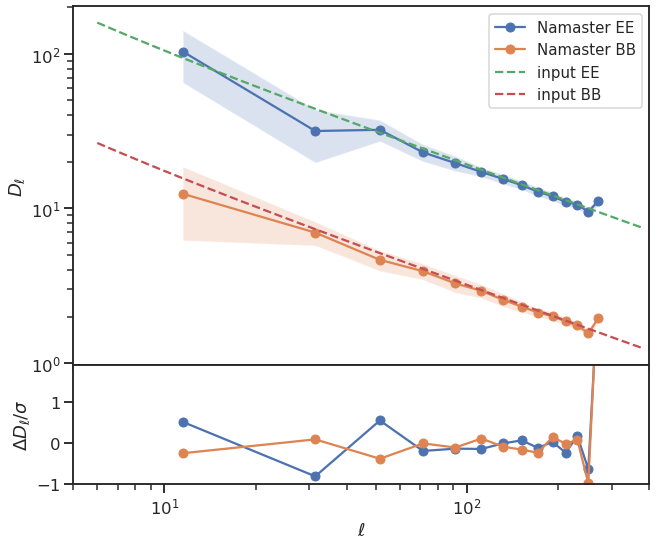

In [346]:
fig1 = plt.figure(1, figsize=(10,8.3))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.loglog(est_use.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est_use.ell_n, BB_mean, 'o-', label = 'Namaster BB')
plt.fill_between(est_use.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.2)
plt.fill_between(est_use.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.2)

plt.loglog(ell[6:], ell[6:]*(ell[6:]+1)/2/np.pi*sl_fake_EE[5:], '--',label = 'input EE')
plt.loglog(ell[6:], ell[6:]*(ell[6:]+1)/2/np.pi*sl_fake_BB[5:], '--',label = 'input BB')
plt.legend(fontsize = 15)
plt.ylabel('$D_{\ell}$')
plt.xlim(5, 400)
frame1.set_xticklabels([])

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(est_use.ell_n, (EE_mean - EE_bin)/EE_std, 'o-', label = 'Namaster EE')
plt.plot(est_use.ell_n, (BB_mean - BB_bin)/BB_std, 'o-', label = 'Namaster BB')
plt.xscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$\Delta D_{\ell} / \sigma$')
plt.ylim(-1,1.9)
plt.xlim(5, 400)

the last one point going up is due to the edge effect, not the real value of ps. If I set the one before the last point as the last point, it still goes up.

# A circular region

In [249]:
from NPTFit import create_mask as cm # Module for creating masks

25532

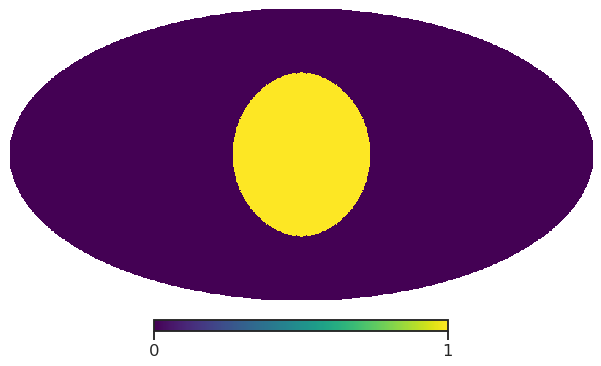

In [269]:
mask_cir = cm.make_mask_total(nside = Nside, mask_ring = True, inner = 42.25, outer = 180, ring_b = 0, ring_l = 0)
hp.mollview(mask_cir,title='', cmap = 'viridis')
mask_cir.sum()

In [411]:
mask_cir

array([False, False, False, ..., False, False, False])

In [444]:
est_cir = BPE(mask_cir, Nside, 20, 300)
est_use = est_cir
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est_use.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])
    
EEs = np.array((EEs));BBs = np.array((BBs));

EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0, ddof = 1)
BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0, ddof = 1)

In [445]:
EE_bin = est_use.b.bin_cell(sl_fake_EE[0:301])
BB_bin = est_use.b.bin_cell(sl_fake_BB[0:301])

(5, 400)

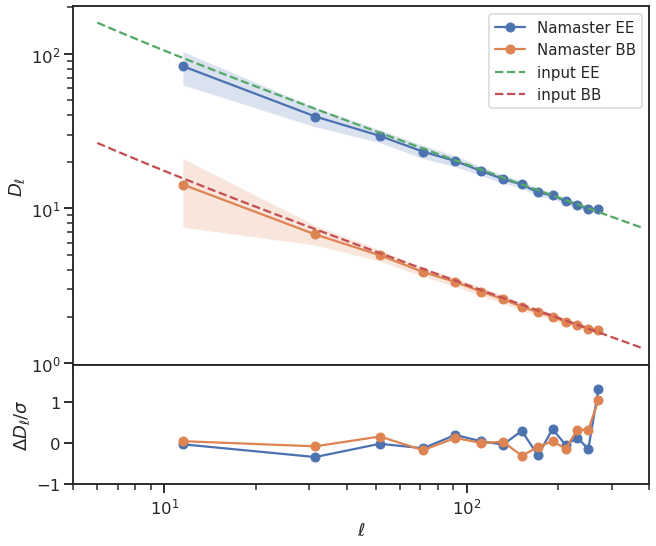

In [446]:
fig1 = plt.figure(1, figsize=(10,8.3))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.loglog(est_use.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est_use.ell_n, BB_mean, 'o-', label = 'Namaster BB')
plt.fill_between(est_use.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.2)
plt.fill_between(est_use.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.2)

plt.loglog(ell[6:], ell[6:]*(ell[6:]+1)/2/np.pi*sl_fake_EE[5:], '--',label = 'input EE')
plt.loglog(ell[6:], ell[6:]*(ell[6:]+1)/2/np.pi*sl_fake_BB[5:], '--',label = 'input BB')
plt.legend(fontsize = 15)
plt.ylabel('$D_{\ell}$')
plt.xlim(5, 400)
frame1.set_xticklabels([])

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(est_use.ell_n, (EE_mean - EE_bin)/EE_std, 'o-', label = 'Namaster EE')
plt.plot(est_use.ell_n, (BB_mean - BB_bin)/BB_std, 'o-', label = 'Namaster BB')
plt.xscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$\Delta D_{\ell} / \sigma$')
plt.ylim(-1,1.9)
plt.xlim(5, 400)

# both region with galactic cut

In [414]:
cut = cm.make_mask_total(nside = Nside, l_mask = False, b_mask = True, b_deg_min = -20, b_deg_max = 20)

In [417]:
mask_both_cut = cut*mask_both

In [447]:
mask_both_cut.sum()/(12*nside**2)

0.09678141276041667

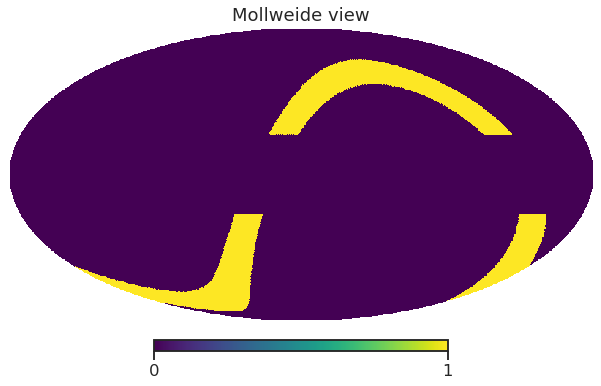

In [418]:
hp.mollview(mask_both_cut, cmap = 'viridis')

In [419]:
pse_results = pse(sl_fake, 50, mask_both_cut, 20, 300, kind = 'auto')

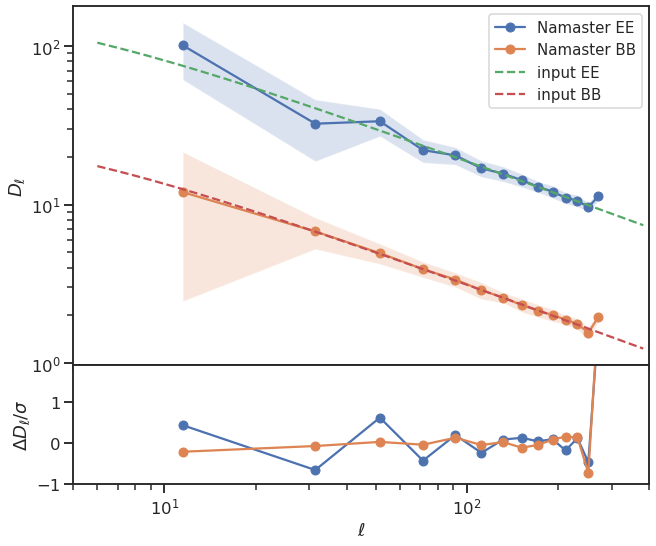

In [443]:
pse_plot(pse_results[0], sl_fake, pse_results[1])

In [456]:
x = np.random.rand(10)
y = np.random.rand(10)

# Auto power spectrum with noise

In [477]:
sky = pysm3.Sky(nside=Nside, preset_strings=["s0"])
spass_signal = sky.get_emission(2.3 * u.GHz)
cbass_signal = sky.get_emission(5 * u.GHz)

array([[49351.26   , 49700.598  , 58242.27   , ..., 63341.74   ,
        68751.93   , 61641.97   ],
       [  543.12256,  -540.42175, -1974.6252 , ...,  -943.17255,
        -1246.5043 ,   752.0127 ],
       [ -953.5335 ,  1547.5968 ,  1050.5798 , ..., -2943.5608 ,
         1765.1376 , -3790.1328 ]], dtype=float32)

In [480]:
est_auto = BPE(mask_both, Nside, 20, 300)

In [531]:
Nl_spass = est_auto.Auto_TEB(noise_128_i[0])
Nl_cbass = est_auto.Auto_TEB(noise_128_i[1])

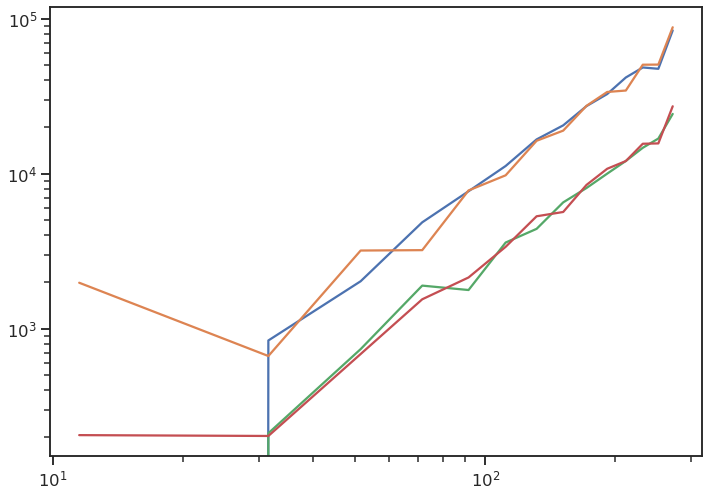

In [498]:
EEs_spa = []; BBs_spa = []; EEs_cba = []; BBs_cba = []; EE_cross = []; BB_cross = []
for i in range(50):
    noise_128_i = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/nside_128/5_fre_noise_%s_uK_RJ_%03d.npy'%(Nside, i))
    spass_obs = np.array((spass_signal)) + noise_128_i[0]
    cbass_obs = np.array((cbass_signal)) + noise_128_i[1]
    
    cross_maps = [spass_obs[1:], cbass_obs[1:]]
    dl_all = est_auto.Cross_EB(cross_maps)
    EEs_spa.append(dl_all[0][:,0,0]); BBs_spa.append(dl_all[2][:,0,0])
    EEs_cba.append(dl_all[0][:,1,1]); BBs_cba.append(dl_all[2][:,1,1])
    EE_cross.append(dl_all[0][:, 0, 1]); BB_cross.append(dl_all[2][:, 0, 1])

In [501]:
def get_mean_and_std(EE, BB):
    EE = np.array((EE)); BB = np.array((BB));
    EE_mean = np.mean(EE, axis = 0); EE_std = np.std(EE, axis = 0, ddof = 1);
    BB_mean = np.mean(BB, axis = 0); BB_std = np.std(BB, axis = 0, ddof = 1);
    
    return EE_mean, EE_std, BB_mean, BB_std

In [503]:
EE_spa_mean , EE_spa_std, BB_spa_mean, BB_spa_std = get_mean_and_std(EEs_spa, BBs_spa)
EE_cba_mean , EE_cba_std, BB_cba_mean, BB_cba_std = get_mean_and_std(EEs_cba, BBs_cba)
EE_cro_mean , EE_cro_std, BB_cro_mean, BB_cro_std = get_mean_and_std(EE_cross, BB_cross)

In [511]:
EE_spa_mean

array([-8.79983926e+07,  2.58205442e+08,  7.24683198e+07,  1.94813162e+08,
        1.05056514e+08,  1.06351251e+08,  1.37545577e+08,  8.67099871e+07,
        5.84345833e+07,  6.38112075e+07,  6.72621359e+07,  5.15962294e+07,
        4.02011532e+07,  6.87155080e+07])

In [510]:
EE_spa_std

array([403475.36771229,  95589.11830933,  76907.70537124, 109991.2849393 ,
       108075.86854119, 111274.24482176, 182146.48722639, 120775.89019619,
       121310.65406302, 112788.13142212, 120389.57037162, 108108.92843562,
       136878.20440524, 192304.70366828])

In [513]:
EE_spa_mean - EE_spa_std,

(array([-8.84018680e+07,  2.58109853e+08,  7.23914121e+07,  1.94703171e+08,
         1.04948438e+08,  1.06239976e+08,  1.37363431e+08,  8.65892112e+07,
         5.83132726e+07,  6.36984194e+07,  6.71417463e+07,  5.14881205e+07,
         4.00642750e+07,  6.85232033e+07]),)

In [514]:
EE_spa_mean + EE_spa_std

array([-8.75949172e+07,  2.58301031e+08,  7.25452275e+07,  1.94923154e+08,
        1.05164590e+08,  1.06462525e+08,  1.37727724e+08,  8.68307629e+07,
        5.85558939e+07,  6.39239957e+07,  6.73825255e+07,  5.17043383e+07,
        4.03380314e+07,  6.89078127e+07])

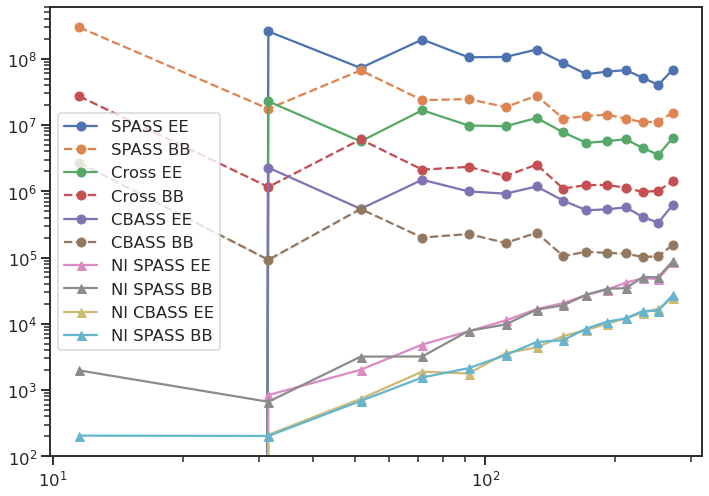

In [540]:
ells = est_auto.ell_n

plt.loglog(ells, EE_spa_mean, 'o-', label = 'SPASS EE')
plt.fill_between(ells, EE_spa_mean - EE_spa_std, EE_spa_mean + EE_spa_std, alpha=0.2)

plt.loglog(ells, BB_spa_mean, 'o--', label = 'SPASS BB')
plt.fill_between(ells, BB_spa_mean - BB_spa_std, BB_spa_mean + BB_spa_std, alpha=0.2)

plt.loglog(ells, EE_cro_mean, 'o-', label = 'Cross EE')
plt.fill_between(ells, EE_cro_mean - EE_cro_std, EE_cro_mean + EE_cro_std, alpha=0.2)

plt.loglog(ells, BB_cro_mean, 'o--', label = 'Cross BB')
plt.fill_between(ells, BB_cro_mean - BB_cro_std, BB_cro_mean + BB_cro_std, alpha=0.2)

plt.loglog(ells, EE_cba_mean, 'o-', label = 'CBASS EE')
plt.fill_between(ells, EE_cba_mean - EE_cba_std, EE_cba_mean + EE_cba_std, alpha=0.2)

plt.loglog(ells, BB_cba_mean, 'o--', label = 'CBASS BB')
plt.fill_between(ells, BB_cba_mean - BB_cba_std, BB_cba_mean + BB_cba_std, alpha=0.2)

plt.loglog(ells, Nl_spass[3], '^-', label = 'Nl SPASS EE')
plt.loglog(ells, Nl_spass[5], '^-', label = 'Nl SPASS BB')

plt.loglog(ells, Nl_cbass[3], '^-', label = 'Nl CBASS EE')
plt.loglog(ells, Nl_cbass[5], '^-', label = 'Nl SPASS BB')

plt.legend()

# Cross power spetrum between SPASS and CBASS with noise

In [ ]:
est_cross = BPE(mask_both, Nside, 20, 300)

In [389]:
cross_maps = [spass_signal[1:], cbass_signal[1:]]

In [390]:
dls = est_cross.Cross_EB(cross_maps)

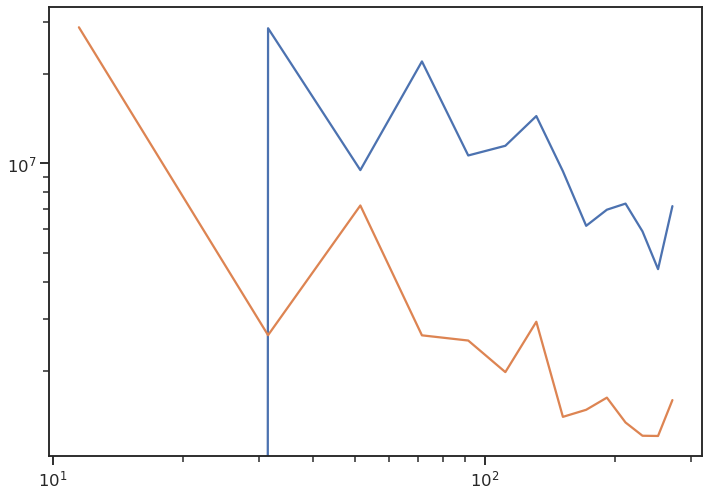

In [397]:
plt.loglog(est_cross.ell_n, dls[0][:,0,1])
plt.loglog(est_cross.ell_n, dls[2][:,0,1])

In [396]:
dls[2][:,0,1]/np.sqrt(dls[2][:,0,0]*dls[2][:,1,1])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [402]:
dls[0][:,0,1]/np.sqrt(dls[0][:,0,0]*dls[0][:,1,1])

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.])

In [403]:
dls[0][:,0,1]

array([-1963489.31555624, 28484015.88309058,  9487898.6699762 ,
       22023091.32808366, 10626283.23201548, 11455052.75541327,
       14419358.49212877,  9405305.60883102,  6161017.04433102,
        6980235.07221761,  7317800.58815916,  5900469.34724863,
        4404178.73915288,  7176412.93565059])

# utility functions

In [442]:
def pse(input_ps, N, mask_in, bin_width, lmax, kind = 'auto'):
    '''
    Parameters
    ----------
    input_ps: fake PS
    bin_width: bin width to calculate the band power.
    lmax: the max-ell to calculate the power spectrum
    N: the number of map realizations generated to calculate the power spetrum.
    
    Returns
    -------
    ell_n: effective ell for the estimator
    EE_mean: mean EE from N realizations of maps
    EE_std;
    BB_mean
    BB_std

    '''
    nside = hp.get_nside(mask_in)
    
    est = BPE(mask_in, nside, bin_width, lmax)
    if kind == 'auto':
        calculator = est.Auto_TEB
    if kind == 'cross':
        calculator = est.Cross_EB
        
    EEs = []; BBs = []
    for i in range(N):
        sync_maps_i = hp.synfast(input_ps, nside = nside, new = True)
        dl_all = calculator(sync_maps_i) #TT TE TB EE EB BB.
        EEs.append(dl_all[3]); BBs.append(dl_all[5])

    EEs = np.array((EEs));BBs = np.array((BBs));

    EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0, ddof = 1)
    BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0, ddof = 1)
    
    return est.ell_n, [EE_mean, EE_std, BB_mean, BB_std]

def pse_plot(ell, input_ps, pse_results):
    '''
    Parameters
    ----------
    ell: effective ells
    pse_results: pse return[1]
    '''
    EE_mean, EE_std, BB_mean, BB_std = pse_results
    
    fig1 = plt.figure(1, figsize=(10,8.3))
    frame1=fig1.add_axes((.1,.3,.8,.6))

    plt.loglog(ell, EE_mean, 'o-', label = 'Namaster EE')
    plt.loglog(ell, BB_mean, 'o-', label = 'Namaster BB')
    plt.fill_between(ell, EE_mean - EE_std, EE_mean + EE_std, alpha=0.2)
    plt.fill_between(ell, BB_mean - BB_std, BB_mean + BB_std, alpha=0.2)
    
    ell_l = np.arange(1, len(input_ps[1]))
    
    plt.loglog(ell_l[5:], ell_l[5:]*(ell_l[5:]+1)/2/np.pi*input_ps[1][6:], '--',label = 'input EE')
    plt.loglog(ell_l[5:], ell_l[5:]*(ell_l[5:]+1)/2/np.pi*input_ps[2][6:], '--',label = 'input BB')
    
    plt.legend(fontsize = 15)
    plt.ylabel('$D_{\ell}$')
    plt.xlim(5, 400)
    frame1.set_xticklabels([])

    frame2=fig1.add_axes((.1,.1,.8,.2))
    plt.plot(ell, (EE_mean - EE_bin)/EE_std, 'o-', label = 'Namaster EE')
    plt.plot(ell, (BB_mean - BB_bin)/BB_std, 'o-', label = 'Namaster BB')
    plt.xscale('log')
    plt.xlabel('$\ell$')
    plt.ylabel('$\Delta D_{\ell} / \sigma$')
    plt.xlim(5, 400)
    plt.ylim(-1,1.9)